# Propper Fitting

This notebook develops an example how one can perform fitting while being honest with the errorbars.

Literature:

1. The bootstrap: a tutorial, Ron Wehrens et al., https://doi.org/10.1016/S0169-7439(00)00102-7
2. Data Analysis and Fitting for Physicists, Peter Young, https://arxiv.org/abs/1210.3781
3. Monte Carlo errors with less errors, Ulli Wolff, https://arxiv.org/abs/hep-lat/0306017

In [1]:
import numpy as np
import scipy.stats as scst
import scipy.optimize as opt

import matplotlib.pyplot as plt
%matplotlib inline

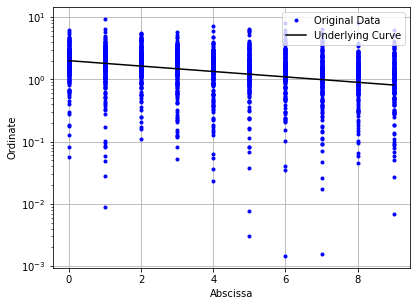

In [2]:
Nx = 10
x = np.arange(0,Nx,1)
xspace = np.linspace(0,Nx-1,100)
A = 2
E = 1e-1
N = 212

# create some gaussian noise on the desired function 
#y = A*np.exp(-E*x) + np.random.randn(N,Nx)/2

# let's do non gaussian noise
#y = A*np.exp(-E*x) + np.random.laplace(0., 1., size=(N,Nx))

# create some gaussian noise but use a sligtly different function
#y = A*np.exp(-E*x) + 1e-5*np.exp(-(4+E)*x) +np.random.randn(N,Nx)

# create some non-gaussian noise and use a sligtly different function
y = A*np.exp(-E*x) + 1e-5*np.exp(-(4+E)*x) + np.random.laplace(0., 1., size=(N,Nx))

def fitfunc1(x,A,E):
    return A*np.exp(-E*x)

def fitfunc2(x,A,E,C):
    return A*np.exp(-E*x)+C

def jac1(x,A,E):
    ex = np.exp(-E*x)
    
    return np.array(
        [ex, -A*x*ex]
    ).T
def jac2(x,A,E,C):
    ex = np.exp(-E*x)
    
    return np.array(
        [ex, -A*x*ex,1]
    ).T

fitfunc = fitfunc1
jac = jac1

plt.figure(figsize = (6.4,4.8))
plt.plot(x,y[0,:], 'b.', label="Original Data")
for n in range(1,N):
    plt.plot(x,y[n,:], 'b.')
plt.plot(np.linspace(0,Nx-1,100),fitfunc(np.linspace(0,Nx-1,100),A,E),'k-', label="Underlying Curve");
plt.grid();
plt.xlabel("Abscissa");
plt.ylabel("Ordinate");
plt.yscale("log")
plt.legend();

In [3]:
def bst_mean(bst_data, data_size, data_est = None, axis = 0):
    
    # bias ~ 1/N
    if data_est is None:
        est = bst_data.mean(axis=axis)
    # bias ~ 1/N**2
    else:
        est = 2*data_est - bst_data.mean(axis=axis)
        
    err = np.sqrt(data_size/(data_size-1))*bst_data.std(axis=axis)
    
    return est,err

def chi2(observations,expectations, dof):
    r"""
        Note: The smaller x2 => The more likely is the fit result correct
            0 < x2 < ∞ 
        Note: The larger  p  => The more likely is the fit result correct
            0 < p < 1
        
        Automation idea:
        You can choose a critical value alpha such that all fits with p < alpha are rejected.
        -> Problematic, to choose alpha is rather arbitrary. 
    """
    
    # compute chi2 from your observations (fit result)
    # and expectations (original data fitted to)
    # ToDo how do I add the (co-)variance
    x2 = np.sum( (observations - expectations)**2 / expectations  )
    
    # compute the p value as survival dist of x2
    p = scst.chi2.sf(x = x2, df = dof)
    
    return [x2,p]

In [4]:
%%time

A0 = 1
E0 = 1

Nbst = 1_000

ys = np.zeros( shape =(Nbst,Nx) )

ps = np.zeros( shape =(Nbst,2) )
pcovs = np.zeros( shape =(Nbst,2,2) )

bestFits = np.zeros(shape = (Nbst, len(xspace)),)

chisqs = np.zeros( shape =(Nbst) )
pvals = np.zeros( shape =(Nbst) )

for k in range(Nbst):
    sampleIds = np.random.randint(0,N,(N,))
    ysample = y[sampleIds,:]
    
    ys[k,:] = ysample.mean(axis=0)
    
    p,pcov = opt.curve_fit(
        f = fitfunc,
        xdata = x,
        ydata = ys[k,:],
        p0 = (A0,E0),
        sigma = ysample.std(axis=0),
        absolute_sigma=True,
        jac = jac
    )
    
    ps[k] = p
    pcovs[k] = pcov
    
    bestFits[k,:] = fitfunc(xspace, *p)
    
    # dof = number of categories (summed over in the chi2 evaluation) - number of parameters (A&E)
    chisqs[k],pvals[k] = chi2( fitfunc(x,*p), ys[k,:], dof = Nx - 2 )

# perform an estimate on the raw data
p,pcov = opt.curve_fit(
    f = fitfunc,
    xdata = x,
    ydata = y.mean(axis=0),
    p0 = (A0,E0),
    sigma = y.std(axis=0),
    absolute_sigma=True,
    jac = jac
)
# obtain the chi2 statistics
chisq, pval = chi2( fitfunc(x,*p), y.mean(axis=0), dof = Nx - 2 )

# Now get the estimate from the bst samples
y_est,y_err = bst_mean(bst_data = ys, data_size = N, axis = 0)
p_est,p_err = bst_mean(bst_data = ps, data_size = N, axis = 0)#, data_est = p[i])
cov_est,cov_err = bst_mean(bst_data = pcovs, data_size = N, axis = 0)#, data_est = pcov)
bestFit_est,bestFit_err = bst_mean(bst_data = bestFits, data_size = N, axis = 0)

# determine the average 
chisq_est, chisq_err = bst_mean( bst_data = chisqs, data_size = N)#, data_est = chisq )
pval_est, pval_err = bst_mean( bst_data = pvals, data_size = N)#, data_est = pval )

# determine the overall chisq statistics from the bst estimates
f = fitfunc(x,*p_est)
chisq_bst, pval_bst = chi2( f, y_est, dof = Nx - 2 )

CPU times: user 480 ms, sys: 3.36 ms, total: 484 ms
Wall time: 485 ms


In [5]:
# Now let us report everything
print("===== Per Bootstrap Sample =====")
for k in range(Nbst):
    print(f"===== n_bst = {k+1}/{Nbst} =====")
    for i in range(len(p)):
        print(f"p[{i}] = {p[i] : .4e} \u00b1 {np.sqrt(pcov[i,i]):.4e}")
    print(f"cov  =\n{pcov}")
    print(f"\u03c7\u00B2 = {chisqs[k]:.4e}, p-val = {pvals[k]:.4e}\n")

# last but not least we just report everything
print("===== Bare Means =====")
for i in range(len(p)):
    print(f"<p[{i}]> = {p[i] : .4e} \u00b1 {np.sqrt(pcov[i,i]):.4e}")
print(f"cov    =")
print(f" [[{pcov[0,0]:.4e} {pcov[1,0]:.4e}]\n"
     +f"  [{pcov[0,1]:.4e} {pcov[1,1]:.4e}]]"
)
print(f"\u03c7\u00B2     = {chisq:.4e}")
print(f"p-value= {pval:.4e}\n")
    
print("===== Bootstrap Means =====")   
print(f"<cov>_bst  =")
print(f" [[{cov_est[0,0]:.4e}\u00b1{cov_err[0,0]:.4e} {cov_est[1,0]:.4e}\u00b1{cov_err[1,0]:.4e}]\n"
     +f"  [{cov_est[0,1]:.4e}\u00b1{cov_err[0,1]:.4e} {cov_est[1,1]:.4e}\u00b1{cov_err[1,1]:.4e}]]"
)
    
print(f"<\u03c7\u00B2>_bst   = {chisq_est:.4e} \u00b1 {chisq_err:.4e}")
print(f"<p-value>_bst = {pval_est:.4e} \u00b1 {pval_err:.4e}\n")

print("========== Final Report ==========")
for i in range(2):
    print(f"<p[{i}]>_bst = {p_est[i]: .4e} \u00b1 {p_err[i]:.4e}")

print(f"Using the bst-estimated parameters: ")
print(f"\u03c7\u00B2   = {chisq_bst:.4e}")
print(f"p-value = {pval_bst:.4e}\n")

===== Per Bootstrap Sample =====
===== n_bst = 1/1000 =====
p[0] =  1.9444e+00 ± 9.8327e-01
p[1] =  9.9226e-02 ± 1.2967e-01
cov  =
[[0.96681932 0.09503474]
 [0.09503474 0.0168132 ]]
χ² = 1.5048e-01, p-val = 1.0000e+00

===== n_bst = 2/1000 =====
p[0] =  1.9444e+00 ± 9.8327e-01
p[1] =  9.9226e-02 ± 1.2967e-01
cov  =
[[0.96681932 0.09503474]
 [0.09503474 0.0168132 ]]
χ² = 1.0390e-01, p-val = 1.0000e+00

===== n_bst = 3/1000 =====
p[0] =  1.9444e+00 ± 9.8327e-01
p[1] =  9.9226e-02 ± 1.2967e-01
cov  =
[[0.96681932 0.09503474]
 [0.09503474 0.0168132 ]]
χ² = 1.8168e-01, p-val = 1.0000e+00

===== n_bst = 4/1000 =====
p[0] =  1.9444e+00 ± 9.8327e-01
p[1] =  9.9226e-02 ± 1.2967e-01
cov  =
[[0.96681932 0.09503474]
 [0.09503474 0.0168132 ]]
χ² = 1.4693e-01, p-val = 1.0000e+00

===== n_bst = 5/1000 =====
p[0] =  1.9444e+00 ± 9.8327e-01
p[1] =  9.9226e-02 ± 1.2967e-01
cov  =
[[0.96681932 0.09503474]
 [0.09503474 0.0168132 ]]
χ² = 1.1152e-01, p-val = 1.0000e+00

===== n_bst = 6/1000 =====
p[0] =  1.

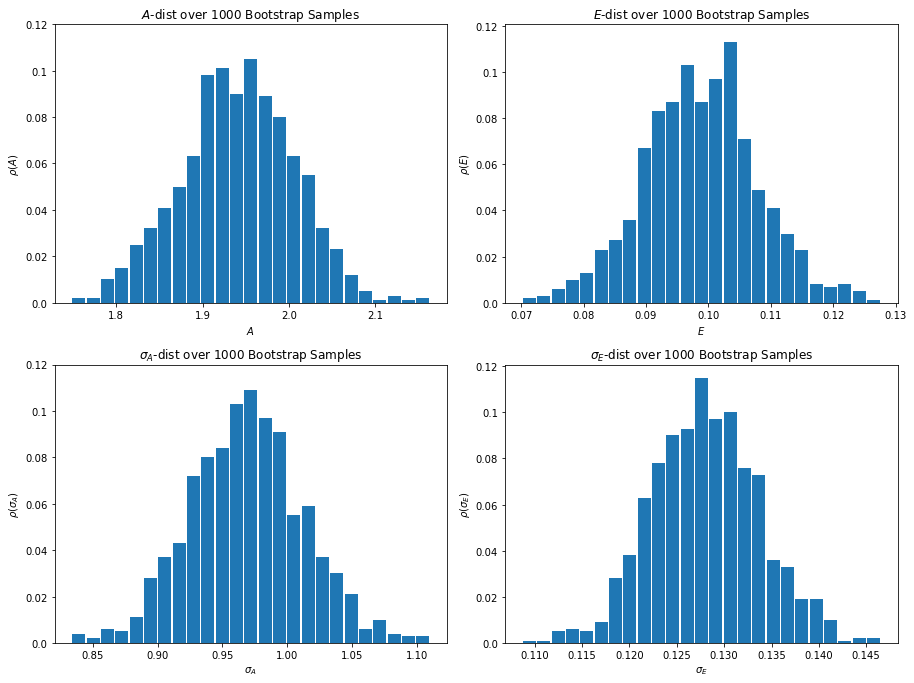

In [6]:
# Now some graphical representation on the above results, we start with the distribution of parameters
plt.figure(figsize = (12.8,9.6))
fig1 = plt.subplot(2,2,1)
plt.hist(ps[:,0],bins='auto', rwidth=0.9)
# normalize the counts -> density (https://stackoverflow.com/a/71624361)
locs, _ = plt.yticks() 
plt.yticks(locs,np.round(locs/Nbst,3))
plt.title(rf"$A$-dist over {Nbst} Bootstrap Samples")
plt.xlabel(r"$A$")
plt.ylabel(r"$\rho(A)$")

fig2 = plt.subplot(2,2,2)
plt.hist(ps[:,1],bins='auto', rwidth=0.9)
# normalize the counts -> density (https://stackoverflow.com/a/71624361)
locs, _ = plt.yticks() 
plt.yticks(locs,np.round(locs/Nbst,3))
plt.title(rf"$E$-dist over {Nbst} Bootstrap Samples")
plt.xlabel(r"$E$")
plt.ylabel(r"$\rho(E)$")

fig3 = plt.subplot(2,2,3,sharey=fig1)
plt.hist(np.sqrt(pcovs[:,0,0]),bins='auto', rwidth=0.9)
# normalize the counts -> density (https://stackoverflow.com/a/71624361)
locs, _ = plt.yticks() 
plt.yticks(locs,np.round(locs/Nbst,3))
plt.title(rf"$\sigma_A$-dist over {Nbst} Bootstrap Samples")
plt.xlabel(r"$\sigma_A$")
plt.ylabel(r"$\rho(\sigma_A)$")

fig4 = plt.subplot(2,2,4,sharey=fig2)
plt.hist(np.sqrt(pcovs[:,1,1]),bins='auto', rwidth=0.9)
# normalize the counts -> density (https://stackoverflow.com/a/71624361)
locs, _ = plt.yticks() 
plt.yticks(locs,np.round(locs/Nbst,3))
plt.title(rf"$\sigma_E$-dist over {Nbst} Bootstrap Samples")
plt.xlabel(r"$\sigma_E$")
plt.ylabel(r"$\rho(\sigma_E)$")

plt.tight_layout()

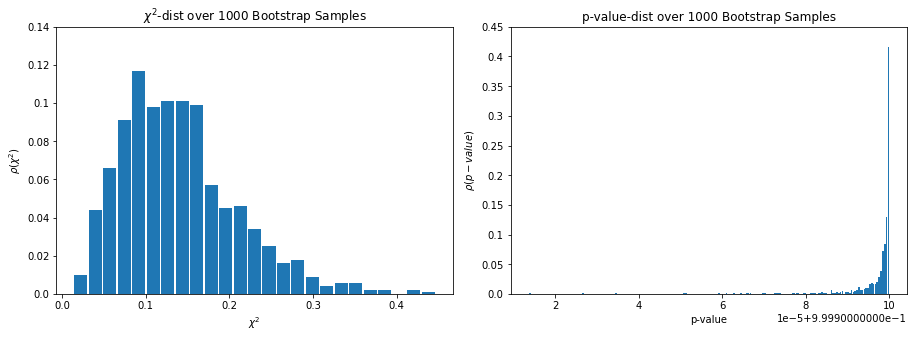

In [7]:
# Next we get the distribution of chi2
plt.figure(figsize = (12.8,4.8))
plt.subplot(1,2,1)
plt.hist(chisqs,bins='auto',rwidth=0.9)
# normalize the counts -> density (https://stackoverflow.com/a/71624361)
locs, _ = plt.yticks() 
plt.yticks(locs,np.round(locs/Nbst,3))
plt.title(rf"$\chi^2$-dist over {Nbst} Bootstrap Samples")
plt.xlabel(r"$\chi^2$")
plt.ylabel(r"$\rho(\chi^2)$")

plt.subplot(1,2,2)
plt.hist(pvals,bins='auto',rwidth=0.9)
# normalize the counts -> density (https://stackoverflow.com/a/71624361)
locs, _ = plt.yticks() 
plt.yticks(locs,np.round(locs/Nbst,3))
plt.title(rf"p-value-dist over {Nbst} Bootstrap Samples")
plt.xlabel(r"p-value")
plt.ylabel(r"$\rho(p-value)$")

plt.tight_layout()

<IPython.core.display.Javascript object>


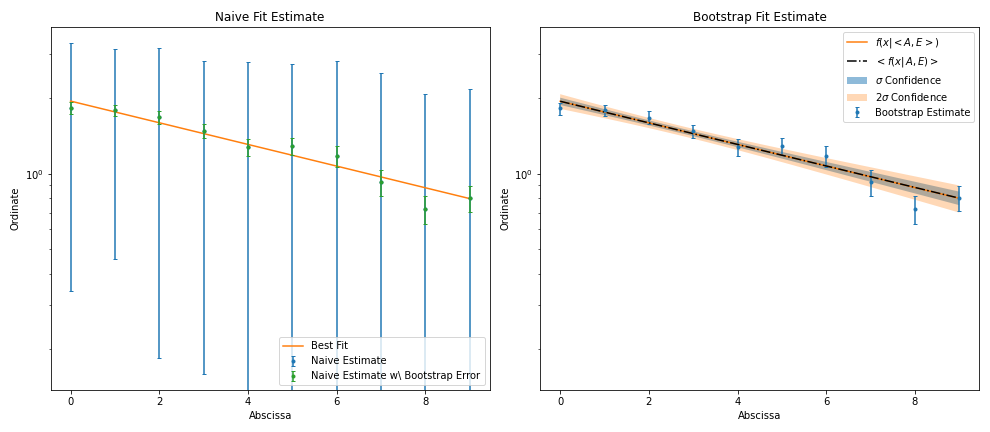

In [13]:
%matplotlib notebook
# plot the fit results to see that it matches (by eye)
plt.figure(figsize = (13.75,6))
ax = plt.subplot(1,2,1) 
plt.errorbar(x, y.mean(axis=0), yerr=y.std(axis=0), fmt='.', capsize=2, label="Naive Estimate");
plt.plot(np.linspace(0,Nx-1,100),fitfunc(np.linspace(0,Nx-1,100),*p),'-', label="Best Fit");
plt.errorbar(x, y.mean(axis=0), yerr=y_err, fmt='.', capsize=2, label="Naive Estimate w\ Bootstrap Error");
plt.xlabel("Abscissa");
plt.ylabel("Ordinate");
plt.title("Naive Fit Estimate")
plt.yscale('log')
plt.legend();
plt.tight_layout()

# plot of the final fit (this may find it's way in papers but you need to clean up the plot ;)
plt.subplot(1,2,2, sharey=ax) 
plt.errorbar(x, y_est, yerr=y_err, fmt='.', capsize=2, label="Bootstrap Estimate");

# notice the chi2 and p-value are reported for this result f(x|<p>)
plt.plot(xspace,fitfunc(xspace,*p_est),'-', label=r"$f(x | <A,E> )$");
# but the confident intervals are reported for <f(x|p)> +/- Δf
# this ansatz is has errors up to Δf^2 but I couldn't find any solution 
# propagating the error Δp of <p> through a non linear f.
# For comparison I also plot <f(x|p)> to ensure that it agrees within errors with f(x|<p>)
plt.plot(xspace,bestFit_est,'k-.', label=r"$<f(x |\, A,E )>$");
plt.fill_between(xspace,bestFit_est-bestFit_err,bestFit_est+bestFit_err, alpha = 0.5, label=r"$\sigma$ Confidence");
plt.fill_between(xspace,bestFit_est-2*bestFit_err,bestFit_est+2*bestFit_err, alpha = 0.3, label=r"$2\sigma$ Confidence");

plt.xlabel("Abscissa");
plt.ylabel("Ordinate");
plt.title("Bootstrap Fit Estimate")
plt.yscale('log')
plt.legend();
plt.tight_layout()